# Trabalho 4 - Operações Geométricas

## Scanner doméstico usando um celular.

Os filhos do professor de visão computacional são aficionados por Star Wars. O maiorzinho queria uma imagem de um storm trooper como plano de fundo para o seu tablet. Contudo, o scanner de casa está quebrado e o salário do professor está muito atrasado. O pior é que o governador Pezão nem sequer diz quando vai pagar os três salário em atraso. Como a grana está curta, o professor resolveu usar câmera do celular. No entanto, é sabido que a imagem obtida pela câmera impõe à imagem original uma geometria projetiva e esta distorção precisa ser compensada já que o garoto ficou muito triste com a qualidade do resultado obtido pela câmera. Felizmente, como o pai dos meninos é professor, ele propôs que seus alunos da Uerj resolvessem este problema como trabalho para a disciplina. Para facilitar a tarefa, o professor fotografou a imagem do storm trooper sobre uma folha de papel A4 que serve como referência. Obtenha a transformação projetiva que recupere a geometria da imagem original e reconstrua-a usando a interpolação bilinear. Veja a seguir a imagem de entrada.

Faça toda a álgebra linear manualmente, das bibliotecas usadas no curso, você só pode usar as funções  ```imread``` e ```imwrite```.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_init = cv.imread('../images/IMG_20170615_082455.jpg', 0)

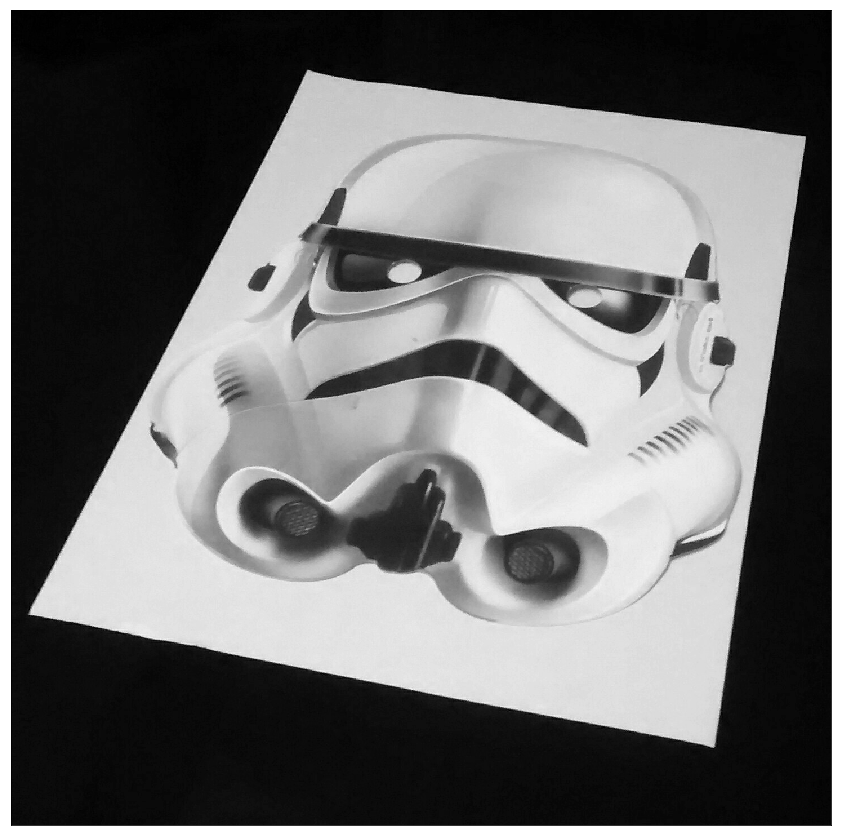

In [3]:
fig = plt.figure(figsize = (21,15))

plt.imshow(img_init, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.show()

In [108]:
# A4 para 150 ppi
# A4 totalmente branco
a4 = np.ones((1754, 1240), dtype = np.uint8) * 255

In [109]:
np.max(a4)

255

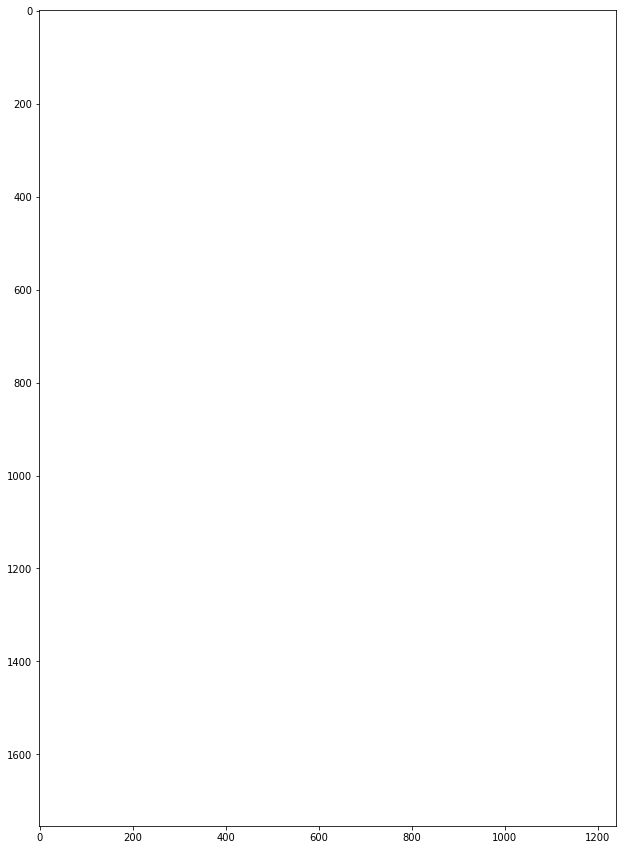

In [110]:
fig = plt.figure(figsize = (21, 15))
# Para mostrar imagem completamente branca tem que colocar o vmin e vmax
plt.imshow(a4, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

In [94]:
a5 = np.uint8([[(30 <= x + y) & (10 >= -x + y) & (-10 <= -x + y) & (50 >= x + y) for y in range(41)] for x in range(41)]) * 255

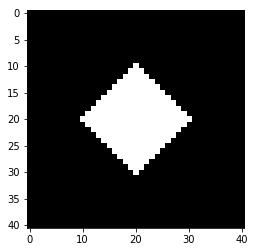

In [95]:
plt.imshow(a5, cmap = 'gray')
plt.show()

In [96]:
def img2binary(img):
    return 60 < img

In [142]:
def roberts(img):
    # Robert's Kernel definition
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return img2binary(robertsx + robertsy).astype(np.uint8)
    

In [143]:
img_roberts = roberts(img_init)

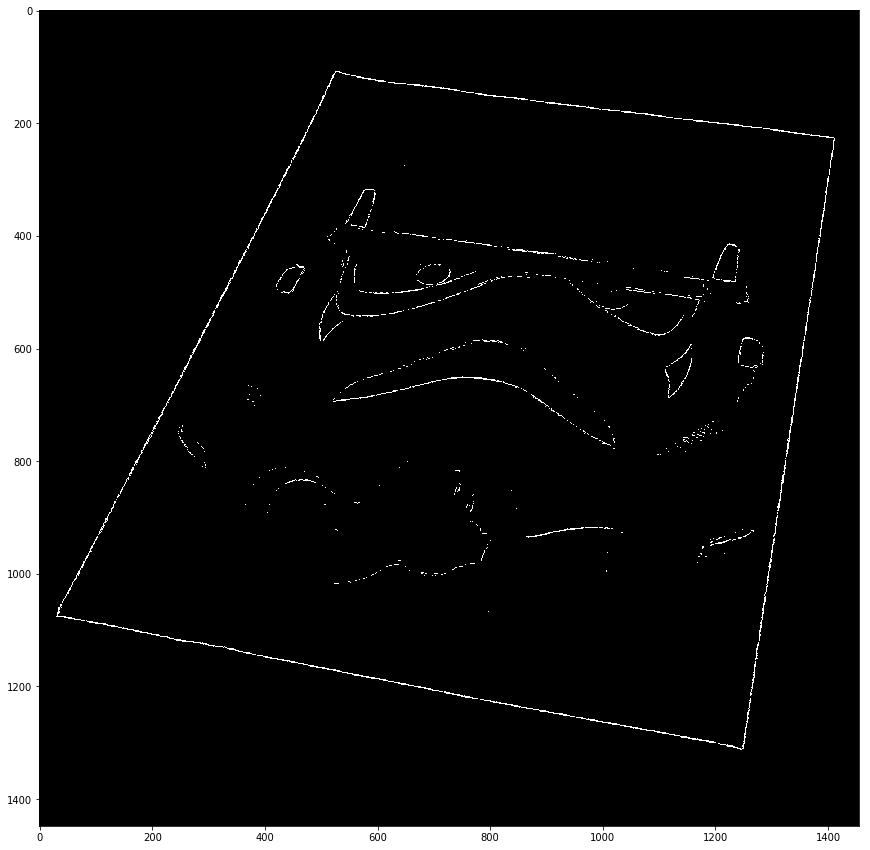

In [144]:
fig = plt.figure(figsize = (21,15))

plt.imshow(img_roberts, cmap = 'gray')
plt.show()

In [163]:
def detect_corners(img):
    b = np.where(img > 0)
    p1 = np.array([b[0][np.argmin(b[0])], b[1][np.argmin(b[0])]])
    p2 = np.array([b[0][np.argmax(b[1])], b[1][np.argmax(b[1])]])
    p3 = np.array([b[0][np.argmax(b[0])], b[1][np.argmax(b[0])]])
    p4 = np.array([b[0][np.argmin(b[1])], b[1][np.argmin(b[1])]])
    
    return np.array([p1, p2, p3, p4])

In [164]:
corners = detect_corners(img_roberts)

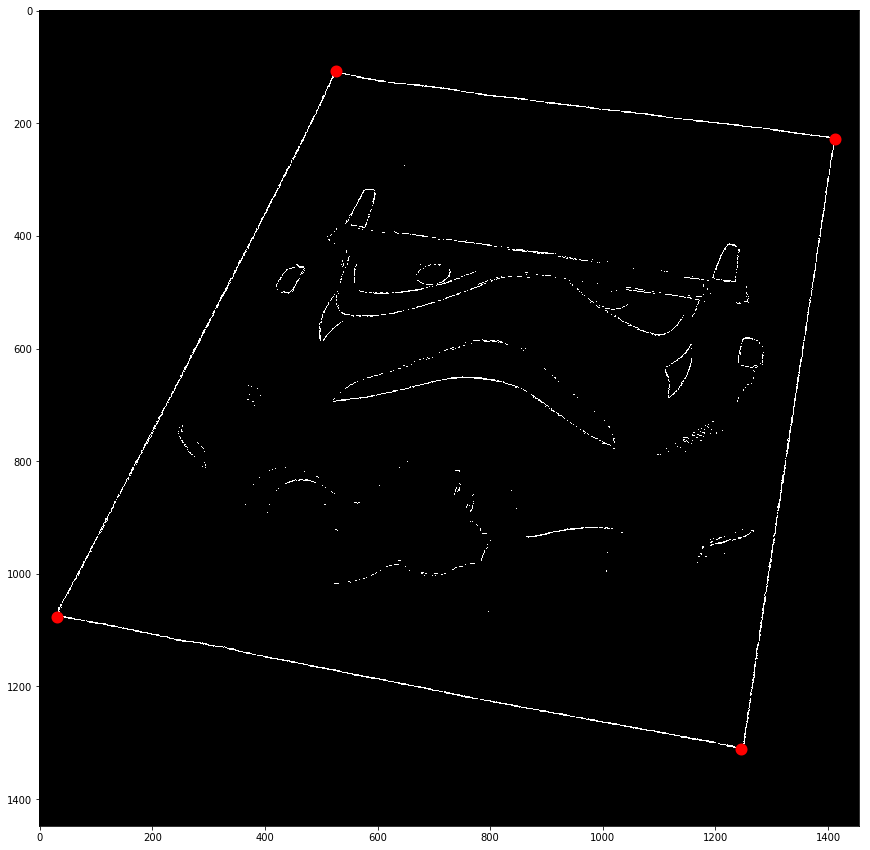

In [165]:
fig = plt.figure(figsize = (21,15))

plt.imshow(img_roberts, cmap = 'gray')
plt.scatter(corners[:,1], corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.show()

In [166]:
a5_roberts = roberts(a5)

In [167]:
a5_corners = detect_corners(a5_roberts)

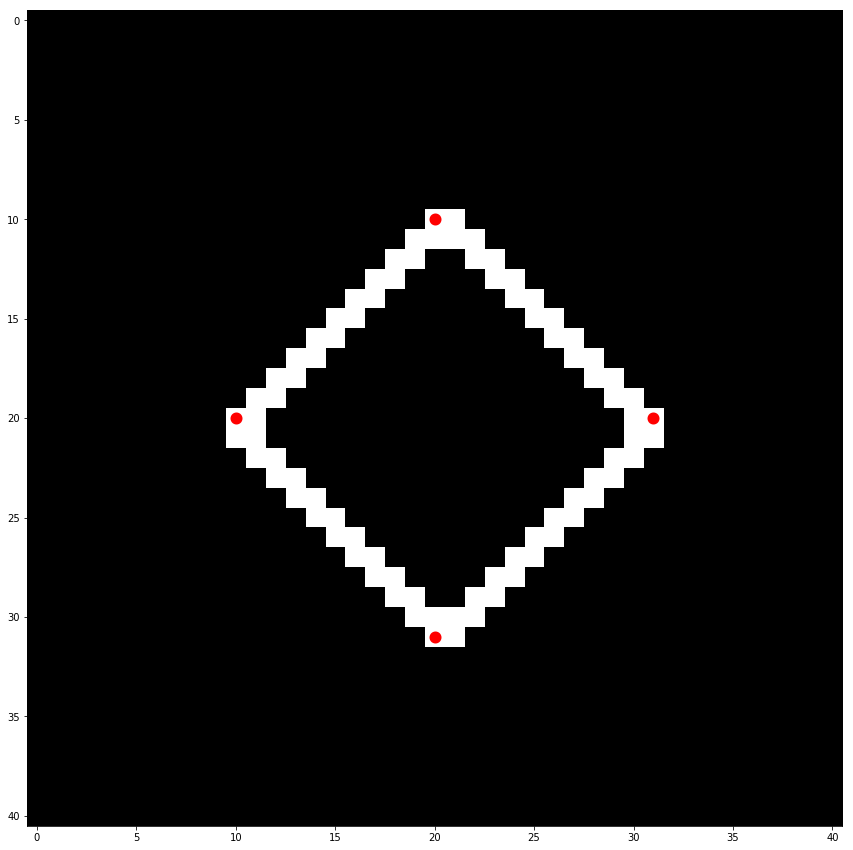

In [168]:
fig = plt.figure(figsize = (21,15))

plt.imshow(a5_roberts, cmap = 'gray')
plt.scatter(a5_corners[:,1], a5_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.show()

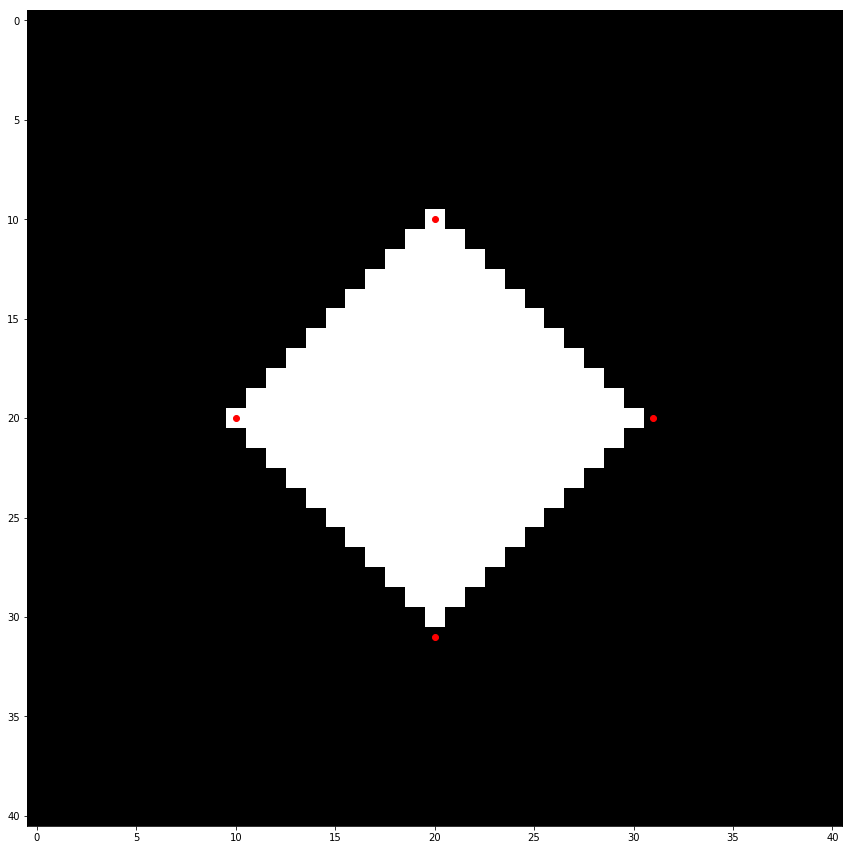

In [169]:
fig = plt.figure(figsize = (21,15))

plt.imshow(a5, cmap = 'gray')
plt.scatter(a5_corners[:,1], a5_corners[:,0], marker = 'o', color = 'red', linewidths = 1)
plt.show()

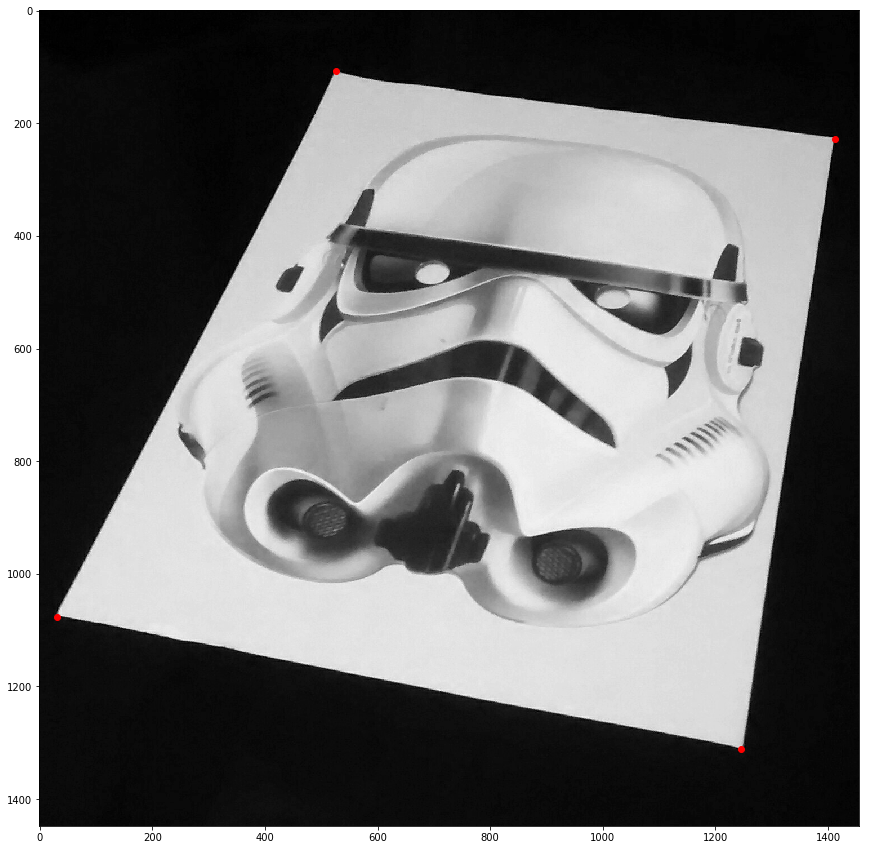

In [170]:
fig = plt.figure(figsize = (21,15))

plt.imshow(img_init, cmap = 'gray')
plt.scatter(corners[:,1], corners[:,0], marker = 'o', color = 'red', linewidths = 1)
plt.show()